In [67]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
# Load the data
df = pd.read_csv('train.csv')

df = df.dropna()  # Remove rows with missing values

df = df.drop_duplicates()  # Remove duplicate rows

# Remove negative values
df = df[df['Quantity'] >= 1]  # Keep only rows with non-negative quantities
df = df[df['Amount'] >= 1]  # Keep only rows with non-negative amounts

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

# Sort the DataFrame by date in ascending order
df.sort_values(by='Date', inplace=True)

# Extract year, month, and quarter from the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

from sklearn.preprocessing import LabelEncoder

# Encode CustomerID and ProductID
le_cust = LabelEncoder()
df['CustomerId'] = le_cust.fit_transform(df['CustomerId'])

# Create a mapping for original and encoded CustomerIDs
customer_mapping = pd.DataFrame({
    'OriginalCustomerId': le_cust.classes_,
    'EncodedCustomerId': range(len(le_cust.classes_))
})

le_prod = LabelEncoder()
df['ProductId'] = le_prod.fit_transform(df['ProductId'])

# Create a mapping for original and encoded ProductIDs
product_mapping = pd.DataFrame({
    'OriginalProductId': le_prod.classes_,
    'EncodedProductId': range(len(le_prod.classes_))
})

# Aggregate data by product, summing quantity and amount
product_sales = df.groupby('ProductId').agg({'Quantity': 'sum', 'Amount': 'sum'}).reset_index()

# Find the top 10 products by quantity sold
top_products = product_sales.sort_values(by='Quantity', ascending=False).head(10)

# Map encoded ProductIDs back to original product names
top_products = top_products.merge(product_mapping, left_on='ProductId', right_on='EncodedProductId', how='left')

# Set index as Date
df.set_index('Date', inplace=True)
df.head()

,InvoiceId,CustomerId,ProductId,Quantity,Amount,Year,Month,Quarter
Date,,,,,,,,
2021-01-02,1703777,116,200,15.0,3173.25,2021,1,1
2021-01-02,1703795,265,200,1.0,213.55,2021,1,1
2021-01-02,1703795,265,200,2.0,338.30,2021,1,1
2021-01-02,1703776,117,200,2.0,310.60,2021,1,1
2021-01-02,1703776,117,200,15.0,2552.25,2021,1,1


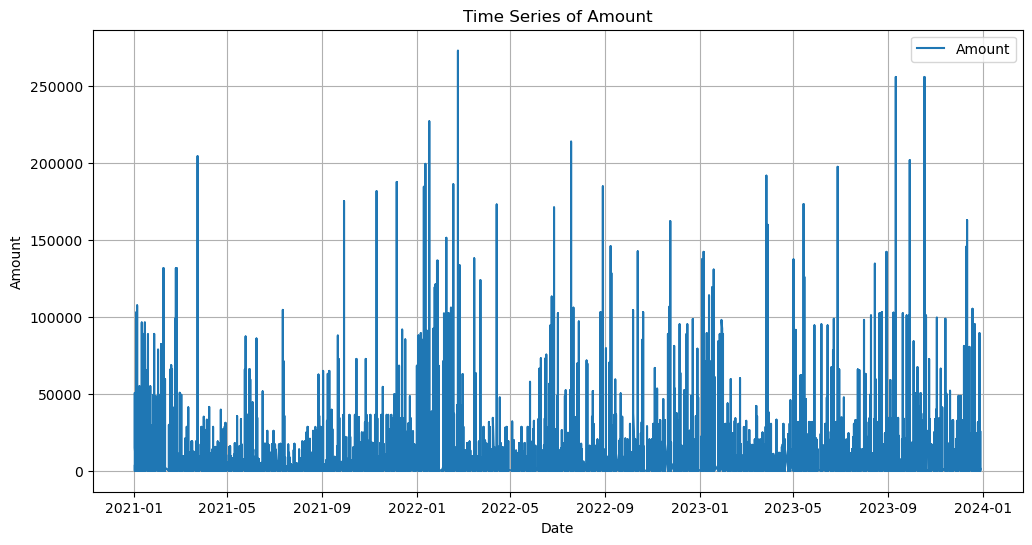

In [69]:
import matplotlib.pyplot as plt

# Plot the time series data for 'Amount'
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Amount'], label='Amount')
plt.title('Time Series of Amount')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

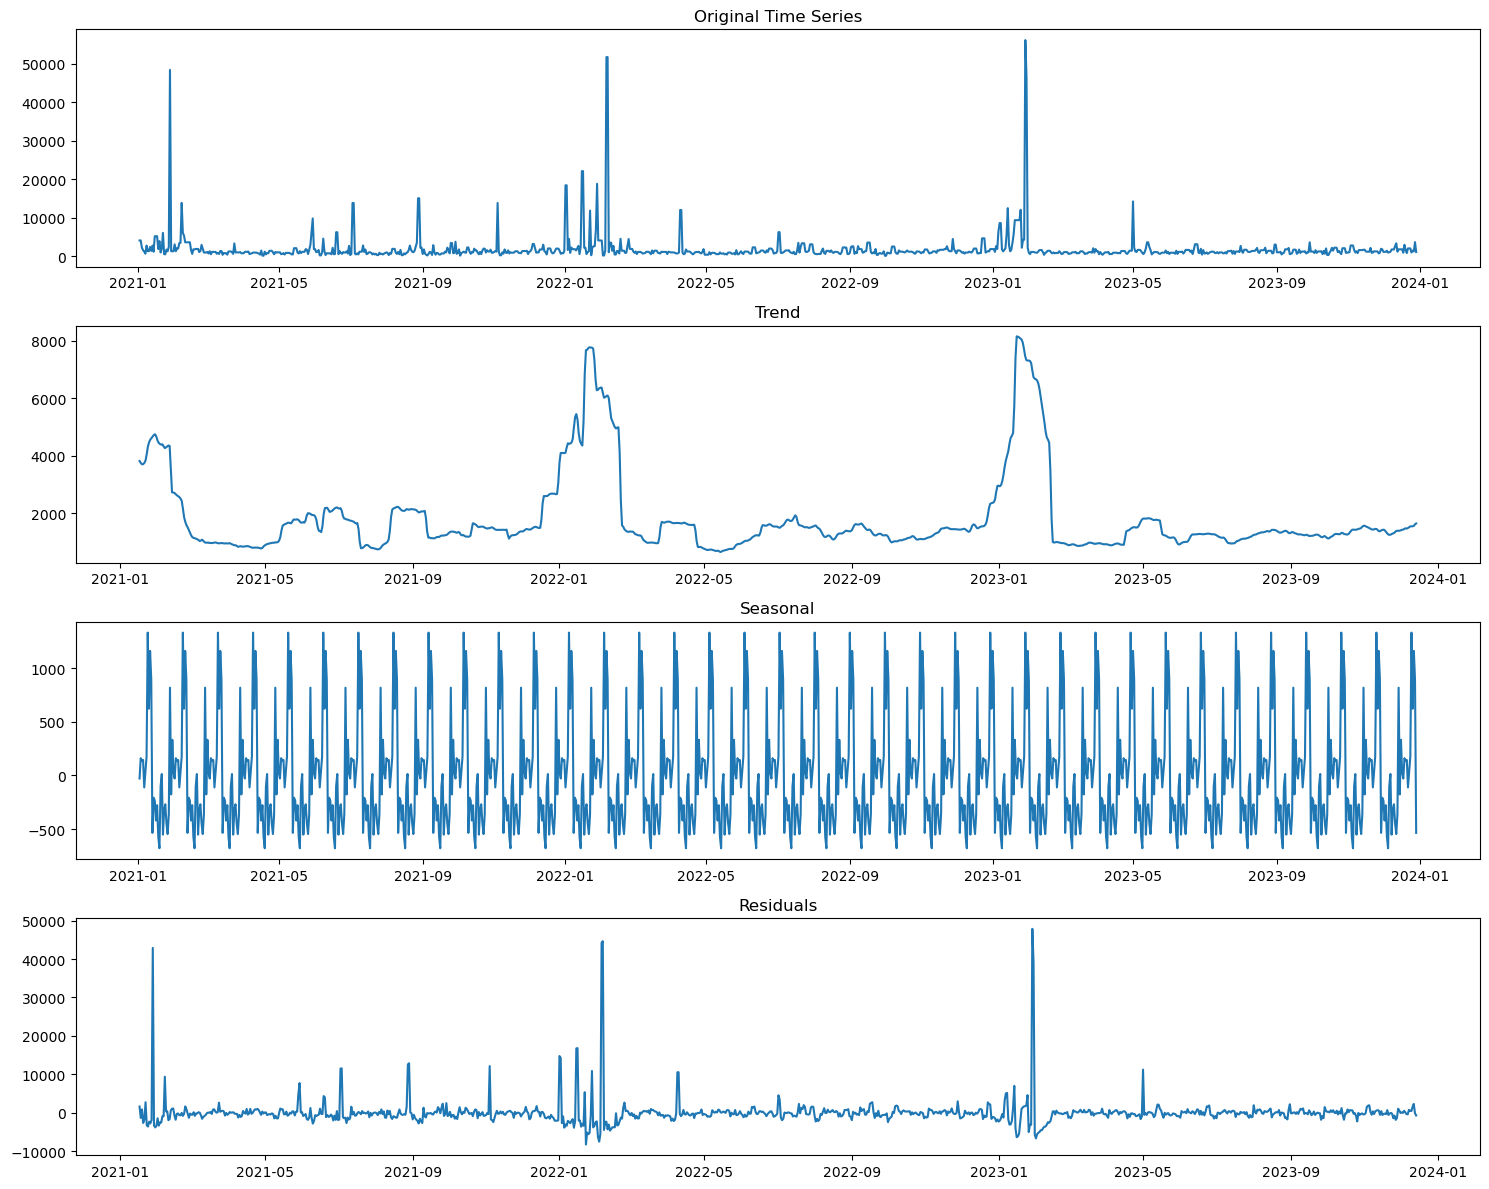


Component Statistics:
Trend mean: 1821.96304264388
Seasonal mean: 3.640530585906957
Residual mean: 8.159857438055123


In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Resample 'Amount' to daily data and fill missing values with 'ffill' (forward fill)
daily_sales = df['Amount'].resample('D').mean().ffill()

# Perform seasonal decomposition on daily sales with a period of 30 days (potential seasonality)
decomposition = seasonal_decompose(daily_sales, period=30)

# Create a subplot figure for better visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Plot the original time series
ax1.plot(daily_sales)
ax1.set_title('Original Time Series')

# Plot the trend component
ax2.plot(decomposition.trend)
ax2.set_title('Trend')

# Plot the seasonal component
ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')

# Plot the residuals (remainder after trend and seasonality are removed)
ax4.plot(decomposition.resid)
ax4.set_title('Residuals')

plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()

# Print statistics about each component (optional)
print("\nComponent Statistics:")
print("Trend mean:", decomposition.trend.mean())
print("Seasonal mean:", decomposition.seasonal.mean())
print("Residual mean:", decomposition.resid.mean())

In [71]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the daily sales data
adf_result = adfuller(daily_sales.dropna())

# Print ADF test results
print('ADF Test Results:')
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Test Results:
ADF Statistic: -8.627226968464372
p-value: 5.885519665456e-14
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


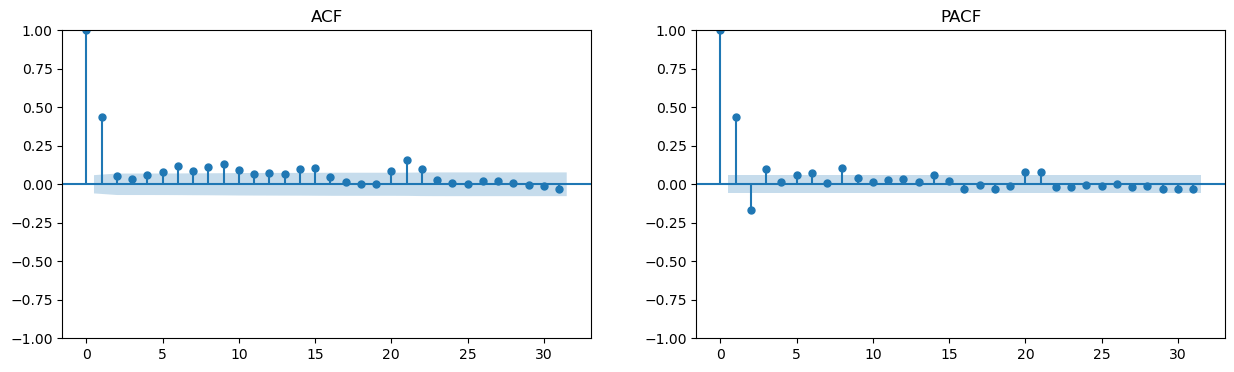

In [72]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(daily_sales, ax=axes[0])
plot_pacf(daily_sales, ax=axes[1])
axes[0].set_title('ACF')
axes[1].set_title('PACF')
plt.show()

In [73]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Resample 'Amount' to daily data and fill missing values with 'ffill'
# daily_sales = df['Amount'].resample('D').mean().ffill()

# Fit ARIMA(1,1,1) model
arima_model = ARIMA(daily_sales, order=(1,1,1))
arima_results = arima_model.fit()

# Fit SARIMA(1,1,1)(1,1,1,12) model
sarima_model = SARIMAX(daily_sales, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()

print("ARIMA Model Summary:")
print(arima_results.summary().tables[1])
print("\nSARIMA Model Summary:")
print(sarima_results.summary().tables[1])

ARIMA Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4370      0.005     87.894      0.000       0.427       0.447
ma.L1         -0.9999      0.006   -172.323      0.000      -1.011      -0.989
sigma2      1.261e+07   4.75e-10   2.66e+16      0.000    1.26e+07    1.26e+07

SARIMA Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4342      0.010     42.670      0.000       0.414       0.454
ma.L1         -0.9999      0.352     -2.838      0.005      -1.690      -0.309
ar.S.L12       0.0348      0.022      1.560      0.119      -0.009       0.079
ma.S.L12      -0.9998      0.343     -2.911      0.004      -1.673      -0.327
sigma2      1.262e+07   2.82e-08   4.48e+14      0.000    1.26e+07    1.26e+07


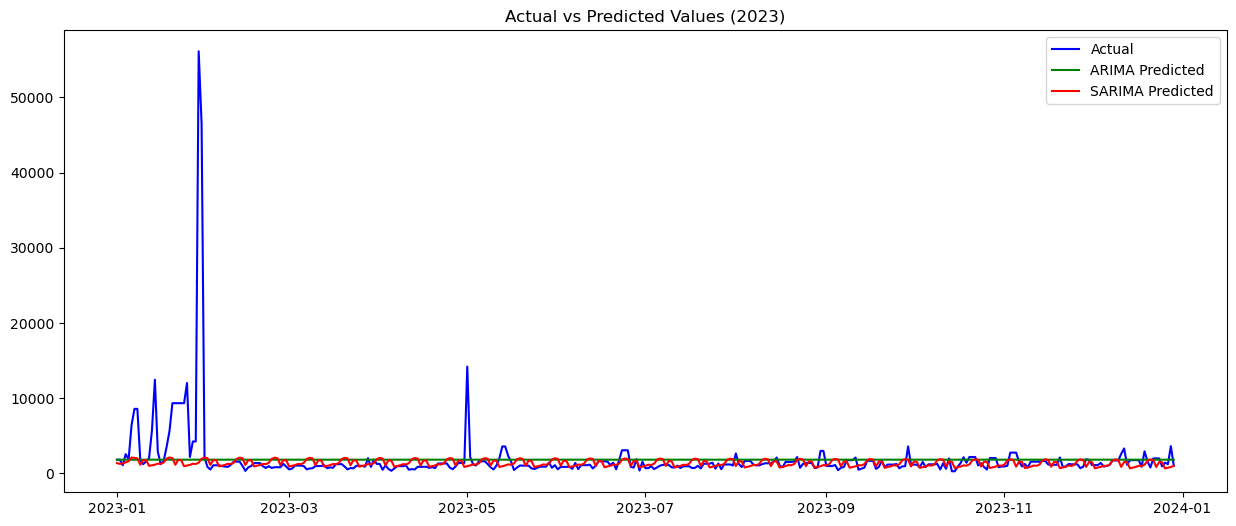


ARIMA Accuracy Metrics:
Mean Absolute Error: 1257.77
Root Mean Squared Error: 4063.21
R-squared Score: -0.00

SARIMA Accuracy Metrics:
Mean Absolute Error: 1112.53
Root Mean Squared Error: 4084.80
R-squared Score: -0.01


In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data into train (2021-2022) and test (2023)
train = daily_sales['2021-01-01':'2022-12-31']
test = daily_sales['2023-01-01':]

# Fit ARIMA model on training data
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Fit SARIMA model on training data
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

# Make predictions for 2023 using both models
arima_predictions = arima_fit.forecast(steps=len(test))
sarima_predictions = sarima_fit.forecast(steps=len(test))

# Calculate accuracy metrics for ARIMA
arima_mae = mean_absolute_error(test, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test, arima_predictions))
arima_r2 = r2_score(test, arima_predictions)

# Calculate accuracy metrics for SARIMA
sarima_mae = mean_absolute_error(test, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_predictions))
sarima_r2 = r2_score(test, sarima_predictions)

# Plot actual vs predicted for both models
plt.figure(figsize=(15, 6))
plt.plot(test.index, test.values, label='Actual', color='blue')
plt.plot(test.index, arima_predictions, label='ARIMA Predicted', color='green')
plt.plot(test.index, sarima_predictions, label='SARIMA Predicted', color='red')
plt.title('Actual vs Predicted Values (2023)')
plt.legend()
plt.show()

print("\nARIMA Accuracy Metrics:")
print(f"Mean Absolute Error: {arima_mae:.2f}")
print(f"Root Mean Squared Error: {arima_rmse:.2f}")
print(f"R-squared Score: {arima_r2:.2f}")

print("\nSARIMA Accuracy Metrics:")
print(f"Mean Absolute Error: {sarima_mae:.2f}")
print(f"Root Mean Squared Error: {sarima_rmse:.2f}")
print(f"R-squared Score: {sarima_r2:.2f}")